# Dog Breed Classification

### Data Preprocessing

In [ ]:
# Download Images from Tsinghua cloud
from tools.download_data import THUCloud
import os
low_data = 'https://cloud.tsinghua.edu.cn/f/80013ef29c5f42728fc8/'
THUCloud(low_data, os.path.join('.', 'data', 'low-images')).download()

In [ ]:
# Download Annotations
!curl https://cg.cs.tsinghua.edu.cn/ThuDogs/low-annotations.zip --output ./data/low-annotations.zip

In [ ]:
!unzip './data/low-images/low\u002Dresolution.zip' -d ./data/low-resolution

In [ ]:
!unzip ./data/low-annotations.zip -d ./data/low-annotations

In [ ]:
!rm './data/low-resolution/low-resolution/~$directoryfilecount.xlsx'

In [ ]:
# Crop Images from bounding boxes
from tools.crop_images import crop_imgs_from_folder
crop_imgs_from_folder('./data/low-resolution/low-resolution',
                      './data/low-annotations/Low-Annotations',
                      './data/low-resolution-cropped')

/home/nikos/PycharmProjects/Dog-breed-recognition/venv/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


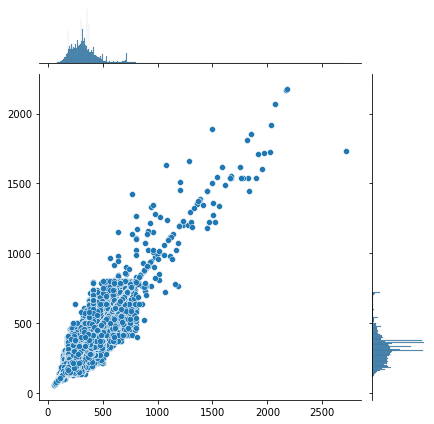

In [14]:
# Plot image dimensions
from tools.image_stats import plot_dimensions_scatterplot

%matplotlib inline
plot_dimensions_scatterplot('./data/low-resolution-cropped')

/home/nikos/PycharmProjects/Dog-breed-recognition/venv/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


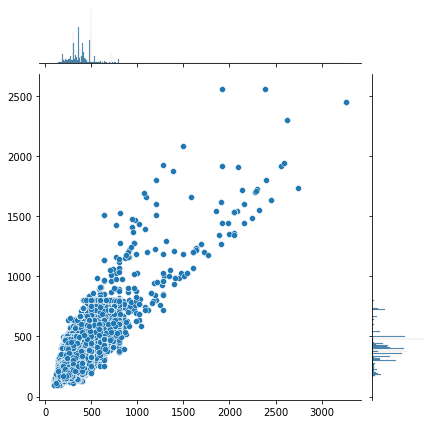

In [16]:
plot_dimensions_scatterplot('./data/low-resolution/low-resolution')

## Dog Detection with YOLOv3

In [ ]:
!curl https://pjreddie.com/media/files/yolov3.weights --output ./dog_detector/yolov3.weights

In [ ]:
from dog_detector.yolo_v3 import make_yolov3_model, WeightReader

# define the model
model = make_yolov3_model()
# load the model weights
weight_reader = WeightReader('./dog_detector/yolov3.weights')
# set the model weights into the model
weight_reader.load_weights(model)
# save the model to file
model.save('./dog_detector/detector.h5')

In [17]:
!curl https://static.thebark.com/sites/default/files/styles/full/public/content/blog/full/dog-sex-gender-male-female.jpg --output dogs.jpg

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100   99k    0   99k    0     0  53978      0 --:--:--  0:00:01 --:--:-- 53950


2021-06-30 23:53:15.944803: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:176] None of the MLIR Optimization Passes are enabled (registered 2)
2021-06-30 23:53:15.965504: I tensorflow/core/platform/profile_utils/cpu_utils.cc:114] CPU Frequency: 1999965000 Hz
2021-06-30 23:53:24.868979: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 22151168 exceeds 10% of free system memory.
2021-06-30 23:53:24.904251: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 22257792 exceeds 10% of free system memory.


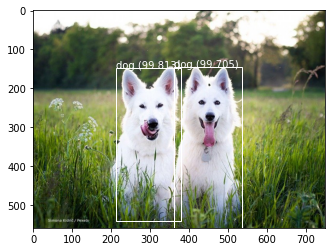

In [19]:
# Detect 
from keras.models import load_model
from dog_detector.detect import detect_in_image, draw_boxes
model = load_model('./dog_detector/detector.h5')
photo_filename = 'dogs.jpg'
v_boxes, v_labels, v_scores = detect_in_image(model, photo_filename, 'dog')
draw_boxes(photo_filename, v_boxes, v_labels, v_scores)

## Train test validation split

In [21]:
import splitfolders
splitfolders.ratio("./data/low-resolution-cropped",
                   output="./data/split-cropped",
                   seed=42, ratio=(.8, .1, .1), group_prefix=None)

Copying files: 70428 files [00:10, 6667.07 files/s] 


## Breed Classification

### Baseline CNN

In [23]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.python.keras.callbacks import EarlyStopping
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation, Dropout, Flatten, Dense, Conv2D, MaxPooling2D
from tensorflow.keras.callbacks import TensorBoard

image_gen = ImageDataGenerator(rescale=1/255)

train_flow = image_gen.flow_from_directory(
    './data/split-cropped/train/',
    class_mode='categorical',
    target_size=(320, 320),
)

val_flow = image_gen.flow_from_directory(
    './data/split-cropped/val/',
    class_mode='categorical',
    target_size=(320, 320),
)

Found 56289 images belonging to 130 classes.
Found 6988 images belonging to 130 classes.


In [ ]:
model = Sequential()
model.add(Conv2D(32, (3, 3), input_shape=(224, 224, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2), padding = 'same'))

model.add(Conv2D(64, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(128, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Flatten())
model.add(Dense(64))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(130))
model.add(Activation('softmax'))

model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])


early_stop = EarlyStopping(monitor='val_loss', patience=2)

tb = TensorBoard(
    log_dir='./simple-cnn-tb-logs/',
    histogram_freq=0, write_graph=True,
    write_images=False, write_steps_per_second=False, update_freq='epoch',
    profile_batch=2, embeddings_freq=0, embeddings_metadata=None
)

results = model.fit_generator(train_flow, epochs=20,
                              validation_data=val_flow,
                              callbacks=[early_stop, tb])

In [ ]:
## We ran the training on Google colab so execution logs are not present

### ResNet 50

In [25]:
from tensorflow.keras import Sequential
from tensorflow.keras.applications.resnet import ResNet50, preprocess_input
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.layers import Input
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.callbacks import TensorBoard

image_gen = ImageDataGenerator(preprocessing_function=preprocess_input)
target_s = (224, 224)

train_flow = image_gen.flow_from_directory(
    './data/split-cropped/train/',
    class_mode='categorical',
    target_size=(320, 320),
    shuffle=True
)

val_flow = image_gen.flow_from_directory(
    './data/split-cropped/val/',
    class_mode='categorical',
    target_size=(320, 320),
    shuffle=True
)

tb = TensorBoard(
    log_dir='./transfer_resnet_tb/', histogram_freq=0, write_graph=True,
    write_images=False, write_steps_per_second=False, update_freq='epoch',
    profile_batch=2, embeddings_freq=0, embeddings_metadata=None
)

Found 56289 images belonging to 130 classes.
Found 6988 images belonging to 130 classes.


2021-07-01 00:01:53.960113: I tensorflow/core/profiler/lib/profiler_session.cc:126] Profiler session initializing.
2021-07-01 00:01:53.960143: I tensorflow/core/profiler/lib/profiler_session.cc:141] Profiler session started.
2021-07-01 00:01:57.529805: I tensorflow/core/profiler/lib/profiler_session.cc:159] Profiler session tear down.


In [26]:
inputs = Input(shape=(224, 224, 3), name='Input_layer')
res_model = ResNet50(include_top=False, weights='imagenet', input_tensor=inputs)

for layer in res_model.layers[:143]:
    layer.trainable = False

model = Sequential()
model.add(res_model)
model.add(Flatten())
model.add(Dense(2048, activation='relu'))
model.add(Dropout(0.6))
model.add(BatchNormalization())
model.add(Dense(1024, activation='relu'))
model.add(Dropout(0.5))
model.add(BatchNormalization())
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.5))
model.add(BatchNormalization())
model.add(Dense(130, activation='softmax'))

model.compile(loss="categorical_crossentropy",
              optimizer="adam",
              metrics=["accuracy"])

2021-07-01 00:02:07.564906: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 822083584 exceeds 10% of free system memory.
2021-07-01 00:02:07.837168: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 822083584 exceeds 10% of free system memory.
2021-07-01 00:02:07.997923: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 822083584 exceeds 10% of free system memory.


In [ ]:
checkpoint = ModelCheckpoint("./Classification/resnet50_check_.h5",
                             monitor='val_accuracy',
                             verbose=1,
                             save_best_only=True,
                             save_weights_only=False,
                             mode='auto',
                             period=1)

early = EarlyStopping(monitor='val_accuracy',
                      min_delta=0,
                      patience=3,
                      verbose=1,
                      mode='auto')

model.fit_generator(
    generator=train_flow,
    epochs=20,
    validation_data=val_flow,
    callbacks=[checkpoint, early, tb])

model.save_weights('./Classification/resnet50_final_.h5')

In [ ]:
for layer in res_model.layers[:143]:
    layer.trainable = True
    
model.load_weights('./Classification/resnet50_check_.h5')


from tensorflow.keras.optimizers import Adam
opt = Adam(learning_rate=0.000001)

model.compile(loss="categorical_crossentropy", optimizer=opt, metrics=["accuracy"])


tb = TensorBoard(
    log_dir='/transfer_resnet_tb_2/', histogram_freq=0, write_graph=True,
    write_images=False, write_steps_per_second=False, update_freq='epoch',
    profile_batch=2, embeddings_freq=0, embeddings_metadata=None
)

model.fit_generator(
    generator=train_flow,
    epochs=20,
    validation_data=val_flow,
    callbacks=[checkpoint, early, tb])

### Inception V3

In [27]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dropout, Flatten, Dense

from tensorflow.keras.applications.inception_v3 import InceptionV3

from tensorflow.keras import optimizers


In [28]:
image_gen = ImageDataGenerator(rescale=1 / 255)
target_s = (224, 224)

train_flow = image_gen.flow_from_directory(
    './data/split-cropped/train/',
    class_mode='categorical',
    target_size=(320, 320),
    shuffle=True
)

val_flow = image_gen.flow_from_directory(
    './data/split-cropped/val/',
    class_mode='categorical',
    target_size=(320, 320),
    shuffle=True
)

from tensorflow.keras.callbacks import TensorBoard

tb = TensorBoard(
    log_dir='./inception_tb_logs/', histogram_freq=0, write_graph=True,
    write_images=False, write_steps_per_second=False, update_freq='epoch',
    profile_batch=2, embeddings_freq=0, embeddings_metadata=None
)

Found 56289 images belonging to 130 classes.
Found 6988 images belonging to 130 classes.


2021-07-01 00:07:22.568944: I tensorflow/core/profiler/lib/profiler_session.cc:126] Profiler session initializing.
2021-07-01 00:07:22.568970: I tensorflow/core/profiler/lib/profiler_session.cc:141] Profiler session started.
2021-07-01 00:07:22.569024: I tensorflow/core/profiler/lib/profiler_session.cc:159] Profiler session tear down.


In [29]:
base_model = InceptionV3(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
base_model.trainable = False

flat1 = Flatten()(base_model.output)
class2 = Dense(4096, activation='relu', name='fc2')(flat1)
y = Dropout(0.2)(class2)
class3 = Dense(4096, activation='relu', name='fc3')(y)
z = Dropout(0.2)(class3)
output = Dense(130, activation='softmax', name='predictions')(z)

87916544/87910968 [==============================] - 57s 1us/step


In [ ]:
checkpoint = ModelCheckpoint("inception_224_checkpoint.h5", monitor='val_accuracy', verbose=1, save_best_only=True,
                             save_weights_only=False, mode='auto', period=1)
early = EarlyStopping(monitor='val_accuracy', min_delta=0, patience=3, verbose=1, mode='auto')

model_final.fit_generator(
    generator=train_flow,
    epochs=20,
    validation_data=val_flow,
    callbacks=[checkpoint, early, tb])

model_final.save_weights("inception_224_final.h5")